# Make sure run from ipykernel located in segmenteverygrain

### module load cuda11

## Import packages

In [1]:
%matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from skimage.measure import regionprops, regionprops_table
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import load_img
from importlib import reload
import segmenteverygrain as seg
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from tqdm import trange

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load models

In [2]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.load_weights('/Users/pjlohr/Documents/GitHub/segmenteverygrain/segmenteverygrain/checkpoints/seg_model')

sam_checkpoint = "/Users/pjlohr/Documents/GitHub/segmenteverygrain/segmenteverygrain/checkpoints/sam_vit_h_4b8939.pth"
device = "mps"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)


2024-11-05 14:21:47.527125: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-11-05 14:21:47.527159: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-11-05 14:21:47.527165: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-11-05 14:21:47.527226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-05 14:21:47.527260: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Run segmentation

Grains are supposed to be well defined in the image; e.g., if a grain consists of only a few pixels, it is unlikely to be detected.

The segmentation can take a few minutes even for medium-sized images, so do not start with large images (downsample them if necessary). Images with ~2000 pixels along their largest dimension are a good start.

In [56]:
from PIL import Image, ImageEnhance
import cv2
from matplotlib import pyplot as plt

fname = '/Users/pjlohr/Documents/GitHub/segmenteverygrain/belay_om/modified_om/mod_0.35 M SnO2  60 m min 50 O oC 0 CB M.tiff'

img = load_img(fname)
# width, height = img.size
# cropped_img = img.crop((0, 0, width // 2, height // 2)) #top left

# enhancer = ImageEnhance.Contrast(cropped_img)
# enhanced_img = enhancer.enhance(2.5)  # Increase contrast by a factor of 2.0
# Display the enhanced image
# enhanced_img.show()

big_im = np.array(img)

# # print(len(big_im))
big_im_pred = seg.predict_big_image(big_im, model, I=256)

# decreasing the 'dbs_max_dist' parameter results in more SAM prompts (and longer processing times):
labels, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=1.0) # Unet prediction

# SAM segmentation, using the point prompts from the Unet:
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, 
                                                                         coords, labels, min_area=2500.0)

segmenting image tiles...


100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


creating masks using SAM...


100%|██████████| 1351/1351 [00:34<00:00, 38.77it/s]


finding overlapping polygons...


828it [00:35, 23.26it/s]


finding best polygons...


100%|██████████| 58/58 [00:17<00:00,  3.27it/s]


creating labeled image...


100%|██████████| 16/16 [00:00<00:00, 249.58it/s]


Use this figure to check the distribution of SAM prompts (= black dots):

In [29]:
# plt.figure(figsize=(15,10))
# plt.imshow(big_im)
# plt.scatter(coords[:,0], coords[:,1], c='k')
# plt.xticks([])
# plt.yticks([]);

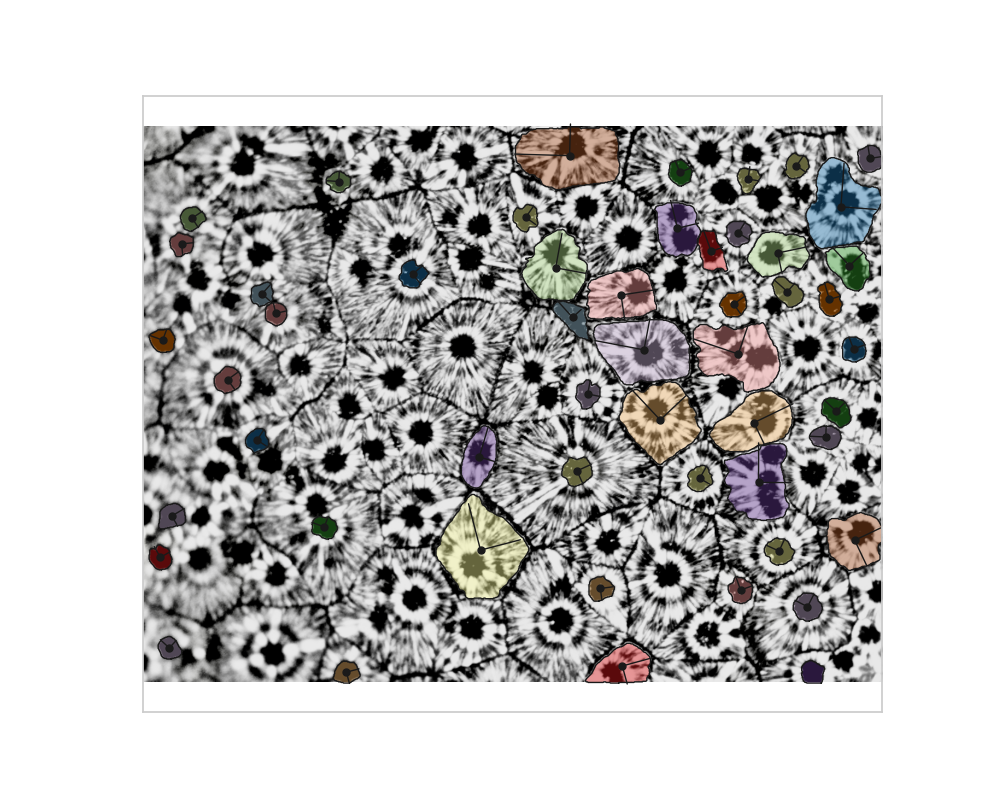

In [55]:
# plot results again if necessary
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(big_im)
seg.plot_image_w_colorful_grains(big_im, all_grains, ax, cmap='Paired')
seg.plot_grain_axes_and_centroids(all_grains, labels, ax, linewidth=1, markersize=10)

## Delete or merge grains in segmentation result
* click on the grain that you want to remove and press the 'x' key
* click on two grains that you want to merge and press the 'm' key (they have to be the last two grains you clicked on)
* press the 'g' key to hide the grain masks (so that you can see the original image better); press the 'g' key again to show the grain masks

In [39]:
grain_inds = []
cid1 = fig.canvas.mpl_connect('button_press_event', 
                              lambda event: seg.onclick2(event, all_grains, grain_inds, ax=ax))
cid2 = fig.canvas.mpl_connect('key_press_event', 
                              lambda event: seg.onpress2(event, all_grains, grain_inds, fig=fig, ax=ax))

Run this cell if you do not want to delete / merge existing grains anymore; it is a good idea to do this before moving on to the next step.

In [40]:
fig.canvas.mpl_disconnect(cid1)
fig.canvas.mpl_disconnect(cid2)

Use this function to update the 'all_grains' list after deleting and merging grains:

100%|██████████| 14/14 [00:00<00:00, 209.48it/s]


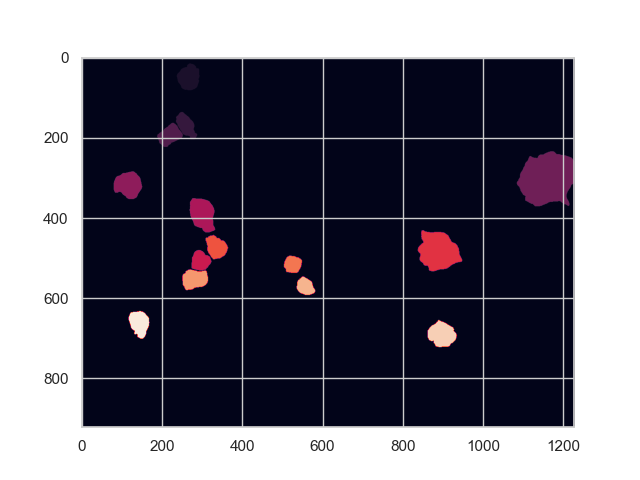

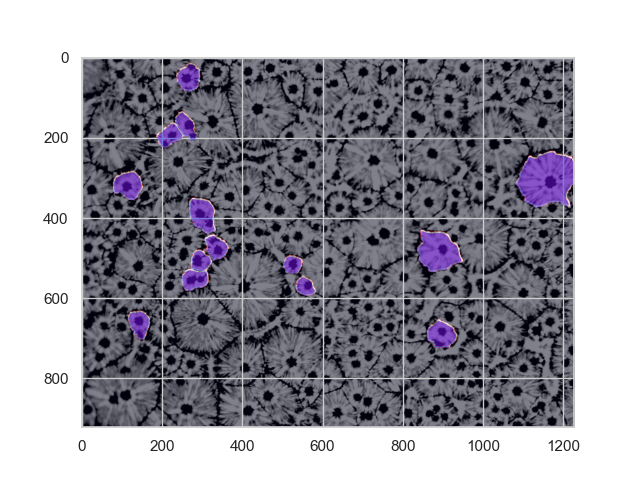

In [41]:
all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, big_im)

Plot the updated set of grains:

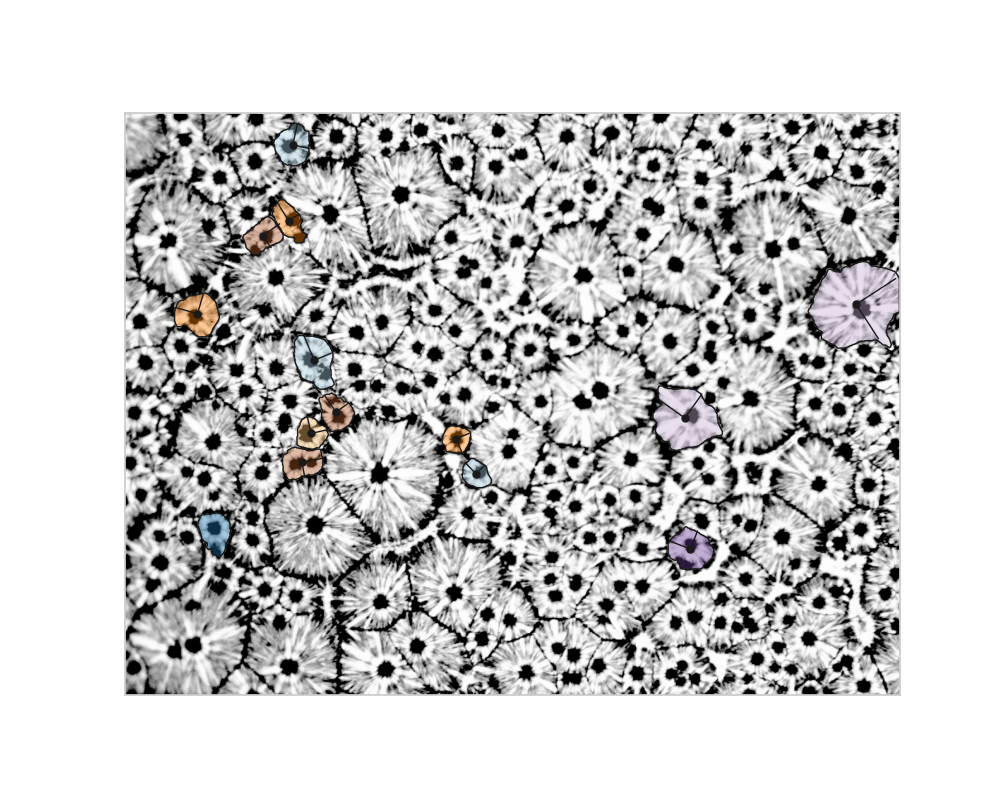

In [42]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(big_im)
plt.xticks([])
plt.yticks([])
seg.plot_image_w_colorful_grains(big_im, all_grains, ax, cmap='Paired')
seg.plot_grain_axes_and_centroids(all_grains, labels, ax, linewidth=1, markersize=10)
plt.xlim([0, np.shape(big_im)[1]])
plt.ylim([np.shape(big_im)[0], 0]);

## Add new grains using the Segment Anything Model

* click on unsegmented grain that you want to add
* press the 'x' key if you want to delete the last grain you added
* press the 'm' key if you want to merge the last two grains that you added
* right click outside the grain (but inside the most recent mask) if you want to restrict the grain to a smaller mask - this adds a background prompt

In [43]:
predictor = SamPredictor(sam)
predictor.set_image(big_im) # this can take a while
coords = []
cid3 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.onclick(event, ax, coords, big_im, predictor))
cid4 = fig.canvas.mpl_connect('key_press_event', lambda event: seg.onpress(event, ax, fig))

In [44]:
fig.canvas.mpl_disconnect(cid3)
fig.canvas.mpl_disconnect(cid4)

After you are done with the deletion / addition of grain masks, run this cell to generate an updated set of grains:

100%|██████████| 141/141 [00:00<00:00, 287.02it/s]


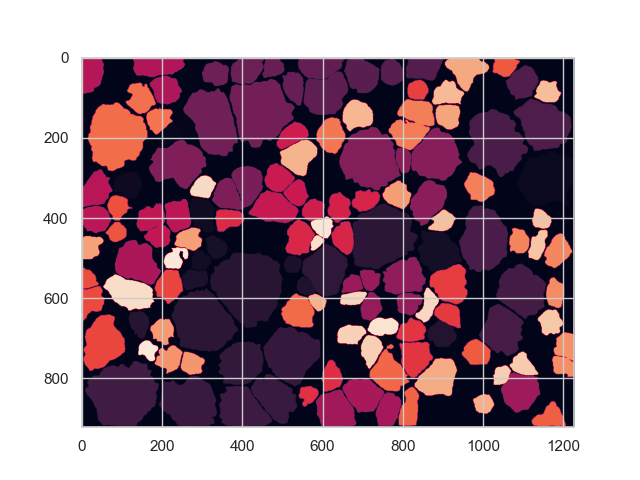

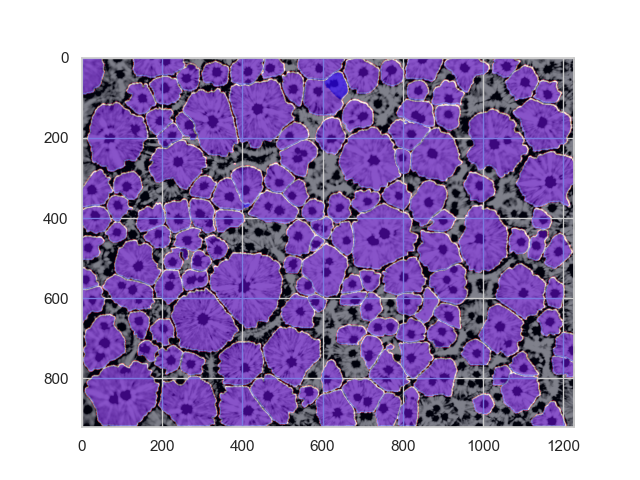

In [46]:
all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, big_im)

label      area  centroid-0   centroid-1  major_axis_length  \
0        1  0.045088   50.455642   265.875089           0.263470   
1        2  0.033184  170.431051   259.110415           0.298464   
2        3  0.036656  194.512003   218.167176           0.263933   
3        4  0.237904  303.114063  1158.469433           0.597742   
4        5  0.057184  318.138500   114.844432           0.285222   
..     ...       ...         ...          ...                ...   
136    137  0.013472  462.152019   584.097387           0.166568   
137    138  0.044848  671.570817   750.304317           0.316408   
138    139  0.033200  422.907952   599.622651           0.219583   
139    140  0.035392  501.136076   232.476944           0.274394   
140    141  0.027376  730.123904   163.980713           0.211799   

     minor_axis_length  orientation  perimeter  max_intensity-0  \
0             0.220751    -0.216955   0.831294            254.0   
1             0.144985     0.555788   0.797921            253.0   
2             0.184079    -0.953604   0.776833            254.0   
3             0.517256    -0.993828   2.065097            254.0   
4             0.261727     1.287205   0.937235            254.0   
..                 ...          ...        ...              ...   
136           0.107041    -0.631469   0.461186            254.0   
137           0.182673    -1.502743   0.854323            254.0   
138           0.203064     1.158101   0.723009            254.0   
139           0.185829    -0.863322   1.017637            254.0   
140           0.175285     0.715636   0.688098            253.0   

     max_intensity-1  max_intensity-2  mean_intensity-0  mean_intensity-1  \
0              254.0            254.0        139.747693        139.747693   
1              253.0            253.0        123.744455        123.744455   
2              254.0            254.0        155.989961        155.989961   
3              254.0            254.0        195.297061        195.297061   
4              254.0            254.0        168.675713        168.675713   
..               ...              ...               ...               ...   
136            254.0            254.0        127.931116        127.931116   
137            254.0            254.0        164.915091        164.915091   
138            254.0            254.0        161.255422        161.255422   
139            254.0            254.0        147.788879        147.789331   
140            253.0            253.0        139.358854        139.358854   

     mean_intensity-2  min_intensity-0  min_intensity-1  min_intensity-2  
0          139.747693              0.0              0.0              0.0  
1          123.744455              0.0              0.0              0.0  
2          155.989961              0.0              0.0              0.0  
3          195.297061              0.0              0.0              0.0  
4          168.675713              0.0              0.0              0.0  
..                ...              ...              ...              ...  
136        127.931116              0.0              0.0              0.0  
137        164.915091              0.0              0.0              0.0  
138        161.255422              0.0              0.0              0.0  
139        147.789331              0.0              0.0              0.0  
140        139.358854              0.0              0.0              0.0  

[141 rows x 17 columns]

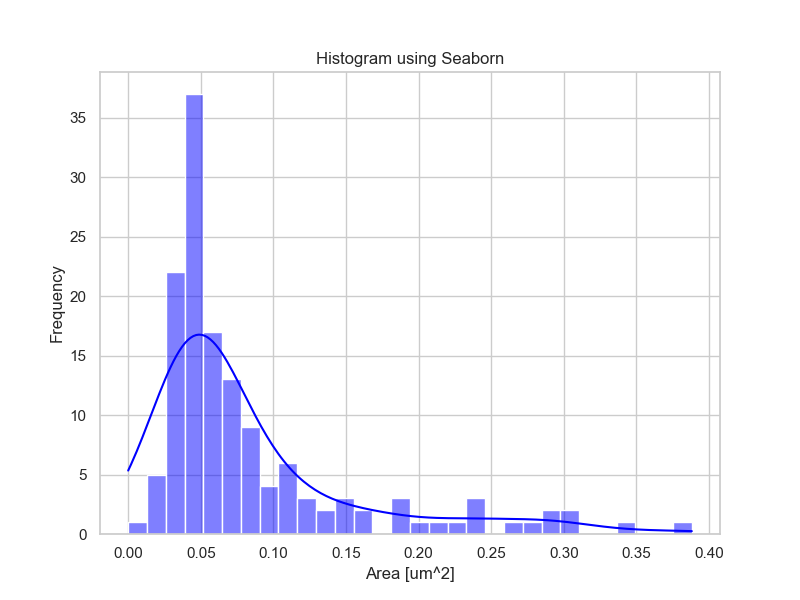

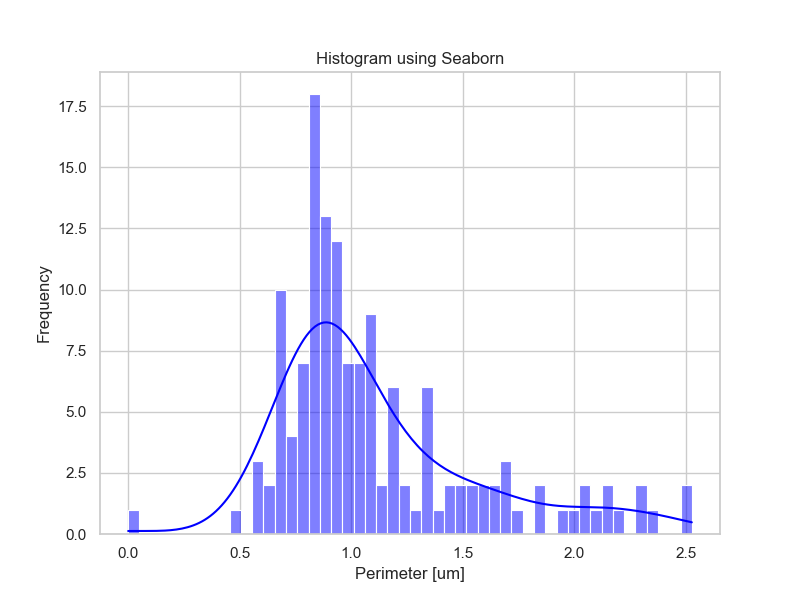

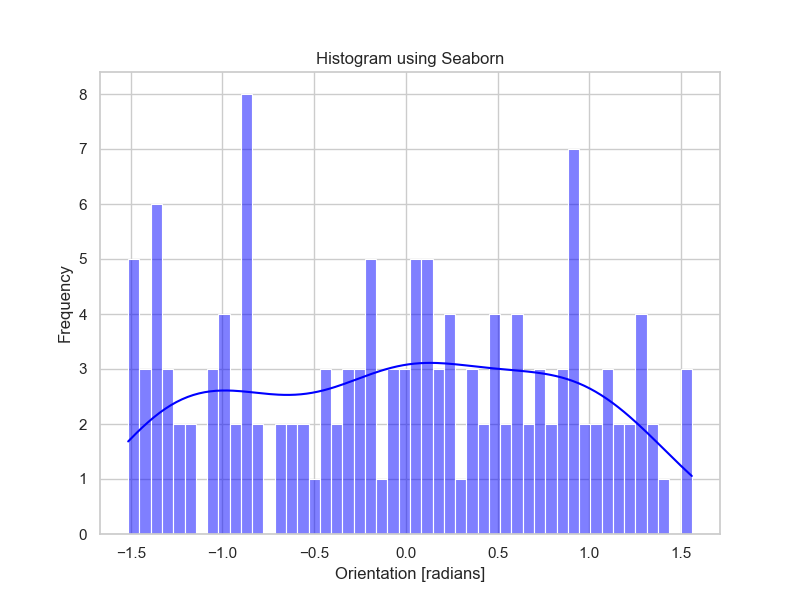

In [47]:
import seaborn as sns

n_of_units = 2 # micron
units_per_pixel = n_of_units/500 # length of scale bar in pixels

props = regionprops_table(labels.astype('int'), intensity_image = big_im, properties =\
        ('label', 'area', 'centroid', 'major_axis_length', 'minor_axis_length', 
         'orientation', 'perimeter', 'max_intensity', 'mean_intensity', 'min_intensity'))
grain_data = pd.DataFrame(props)

grain_data['major_axis_length'] = grain_data['major_axis_length'].values*units_per_pixel
grain_data['minor_axis_length'] = grain_data['minor_axis_length'].values*units_per_pixel
grain_data['perimeter'] = grain_data['perimeter'].values*units_per_pixel
grain_data['area'] = grain_data['area'].values*units_per_pixel**2

display(grain_data)

# Create a histogram using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(grain_data['area'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel('Area [um^2]')
plt.ylabel('Frequency')
plt.title('Histogram using Seaborn')

# Show the plot
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(grain_data['perimeter'], bins=50, kde=True, color='blue')

# Add labels and title
plt.xlabel('Perimeter [um]')
plt.ylabel('Frequency')
plt.title('Histogram using Seaborn')

# Show the plot
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(grain_data['orientation'], bins=50, kde=True, color='blue')

# Add labels and title
plt.xlabel('Orientation [radians]')
plt.ylabel('Frequency')
plt.title('Histogram using Seaborn')

# Show the plot
plt.show()

grain_data.to_csv('/Users/pjlohr/Documents/GitHub/segmenteverygrain/belay_om/0.35M_SnO2_60mmin_50_O_oC_0_CBM.csv')

## Get grain size distribution

Run this cell and then click (left mouse button) on one end of the scale bar in the image and click (right mouse button) on the other end of the scale bar:

In [48]:
cid5 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.click_for_scale(event, ax))

Use the length of the scale bar in pixels (it should be printed above) to get the scale of the image (in units / pixel):

In [49]:
# n_of_units = 2 # centimeters in the case of 'IMG_5208_image.png'
# units_per_pixel = n_of_units/500 # length of scale bar in pixels

In [50]:
# props = regionprops_table(labels.astype('int'), intensity_image = big_im, properties =\
#         ('label', 'area', 'centroid', 'major_axis_length', 'minor_axis_length', 
#          'orientation', 'perimeter', 'max_intensity', 'mean_intensity', 'min_intensity'))
# grain_data = pd.DataFrame(props)
# grain_data['major_axis_length'] = grain_data['major_axis_length'].values*units_per_pixel
# grain_data['minor_axis_length'] = grain_data['minor_axis_length'].values*units_per_pixel
# grain_data['perimeter'] = grain_data['perimeter'].values*units_per_pixel
# grain_data['area'] = grain_data['area'].values*units_per_pixel**2

In [51]:
grain_data.head()

label      area  centroid-0   centroid-1  major_axis_length  \
0      1  0.045088   50.455642   265.875089           0.263470   
1      2  0.033184  170.431051   259.110415           0.298464   
2      3  0.036656  194.512003   218.167176           0.263933   
3      4  0.237904  303.114063  1158.469433           0.597742   
4      5  0.057184  318.138500   114.844432           0.285222   

   minor_axis_length  orientation  perimeter  max_intensity-0  \
0           0.220751    -0.216955   0.831294            254.0   
1           0.144985     0.555788   0.797921            253.0   
2           0.184079    -0.953604   0.776833            254.0   
3           0.517256    -0.993828   2.065097            254.0   
4           0.261727     1.287205   0.937235            254.0   

   max_intensity-1  max_intensity-2  mean_intensity-0  mean_intensity-1  \
0            254.0            254.0        139.747693        139.747693   
1            253.0            253.0        123.744455        123.744455   
2            254.0            254.0        155.989961        155.989961   
3            254.0            254.0        195.297061        195.297061   
4            254.0            254.0        168.675713        168.675713   

   mean_intensity-2  min_intensity-0  min_intensity-1  min_intensity-2  
0        139.747693              0.0              0.0              0.0  
1        123.744455              0.0              0.0              0.0  
2        155.989961              0.0              0.0              0.0  
3        195.297061              0.0              0.0              0.0  
4        168.675713              0.0              0.0              0.0

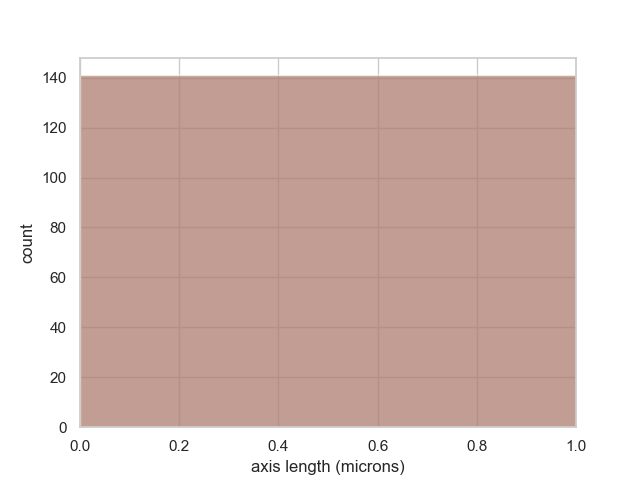

In [52]:
plt.figure()
plt.hist(grain_data['major_axis_length'], np.arange(0, 200, 5), alpha=0.5)
plt.hist(grain_data['minor_axis_length'], np.arange(0, 200, 5), alpha=0.5)

plt.xlabel('axis length (microns)')
plt.xlim(0, 1)
plt.ylabel('count');

## Save mask and grain labels to PNG files

In [53]:
dirname = '/Users/zoltan/Dropbox/Segmentation/images/'
# write grayscale mask to PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_mask.png', mask_all)
# Save the image as a PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_image.png', cv2.cvtColor(big_im, cv2.COLOR_BGR2RGB))

False